# Spacetime Ripple Simulation with Relativistic Effects

This notebook demonstrates the behavior of particles and wave functions in a 4D spacetime grid. It includes:
- Converting between 4D spherical and Cartesian coordinates.
- Simulating wave propagation.
- Modeling particle paths with relativistic effects.
- Visualizing results.

In [ ]:
# Import Required Libraries
from scipy.constants import c as speed_of_light
from numba import njit
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


## Define StateSpace Class
This class contains functions for:
- Converting between 4D spherical and Cartesian coordinates.
- Computing relativistic effects such as time dilation and wave propagation.
- Modeling spin and antiparticle wave functions.

In [ ]:
class RippleKleinGordonSimulator:
    def __init__(self, L, T, c, dx, dt, m=0, r0=1):
        """
        Initialize simulation parameters.
        """
        self.L = L  # Length of spatial domain
        self.T = T  # Total simulation time
        self.c = c  # Speed of light
        self.dx = dx  # Spatial resolution
        self.dt = dt  # Time step size
        self.m = m  # Mass term for Klein-Gordon equation
        self.r0 = r0  # Initial ripple radius

        self.nx = int(L / dx) + 1
        self.nt = int(T / dt) + 1

        self.x = np.linspace(-L / 2, L / 2, self.nx)  # Spatial grid
        self.t = np.linspace(0, T, self.nt)  # Time grid

        self.Psi = np.zeros((self.nt, self.nx))  # Wavefunction
        self.energy = np.zeros(self.nt)  # Total energy over time

    def initial_wave_profile(self, x, A=1, k=2 * np.pi, phi=0):
        envelope = np.exp(-0.5 * (x / self.L)**2)
        return A * envelope * np.cos(k * x + phi) * (np.abs(x) <= self.r0)

    def initial_wave_velocity(self, x, A=1, k=2 * np.pi, phi=0):
        """Initialize the wavefunction's time derivative."""
        return -A * self.c * k * np.sin(k * x + phi)

    @staticmethod
    @njit
    def solve_wave_equation_1d(Psi, nt, nx, c, dt, dx, m2):
        """
        Numerical solution of the Klein-Gordon equation without ripple effects.
        """
        for n in range(1, nt - 1):
            for i in range(1, nx - 1):
                # Update wavefunction using the Klein-Gordon equation
                Psi[n + 1, i] = (
                    2 * Psi[n, i]
                    - Psi[n - 1, i]
                    + (c * dt / dx) ** 2 * (Psi[n, i + 1] - 2 * Psi[n, i] + Psi[n, i - 1])
                    - (dt ** 2) * m2 * Psi[n, i]
                )

            # Check for numerical stability
            if np.any(np.isnan(Psi[n + 1, :])) or np.any(np.isinf(Psi[n + 1, :])):
                raise ValueError(f"Numerical instability detected at step {n}.")

        return Psi

    def solve(self, A=1, k=2 * np.pi / 5, phi=0, plot=False):
        """
        Solve the Klein-Gordon equation with ripple effects.
        """
        self.Psi[0, :] = self.initial_wave_profile(self.x, A=A, k=k, phi=phi)
        self.Psi[1, :] = (
            self.Psi[0, :] + self.dt * self.initial_wave_velocity(self.x, A=A, k=k, phi=phi)
        )

        m2 = (self.m / self.c) ** 2
        self.Psi = self.solve_wave_equation_1d(
            self.Psi, self.nt, self.nx, self.c, self.dt, self.dx, m2
        )
        self.compute_energy()

        if plot:
            self.visualize_wave()
            self.visualize_energy()

    def compute_energy(self):
        """
        Compute and store the total energy of the system over time.
        """
        for n in range(1, self.nt - 1):
            # Kinetic energy
            time_derivative = (self.Psi[n + 1, :] - self.Psi[n - 1, :]) / (2 * self.dt)
            kinetic_energy = 0.5 * time_derivative ** 2

            # Potential energy
            space_derivative = np.zeros_like(self.Psi[n, :])
            space_derivative[1:-1] = (self.Psi[n, 2:] - self.Psi[n, :-2]) / (2 * self.dx)
            potential_energy = 0.5 * (
                (self.c * space_derivative) ** 2 + self.m ** 2 * self.Psi[n, :] ** 2
            )

            # Total energy density
            self.energy[n] = np.sum(kinetic_energy + potential_energy) * self.dx  # Integrate over space

    def visualize_wave(self):
        """
        Visualize the wavefunction over space and time.
        """
        plt.figure(figsize=(10, 6))
        plt.imshow(
            self.Psi,
            extent=[-self.L / 2, self.L / 2, 0, self.T],
            origin="lower",
            aspect="auto",
            cmap="viridis",
        )
        plt.colorbar(label="Wavefunction Ψ")
        plt.xlabel("Position $x$")
        plt.ylabel("Time $t$")
        plt.title("Wave Propagation with Ripple Effects")
        plt.show()

    def visualize_energy(self):
        """
        Plot the total energy over time.
        """
        plt.figure(figsize=(8, 5))
        plt.plot(self.t, self.energy, label="Total Energy", color="blue")
        plt.xlabel("Time $t$")
        plt.ylabel("Total Energy $E(t)$")
        plt.title("Energy Conservation")
        plt.legend()
        plt.grid()
        plt.show()


## Simulate Wave Propagation
We solve the Klein-Gordon wave equation in 1D.

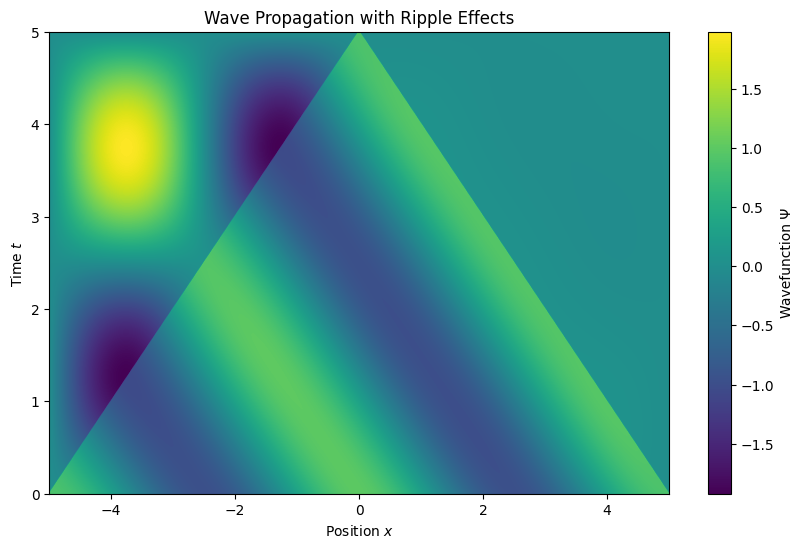

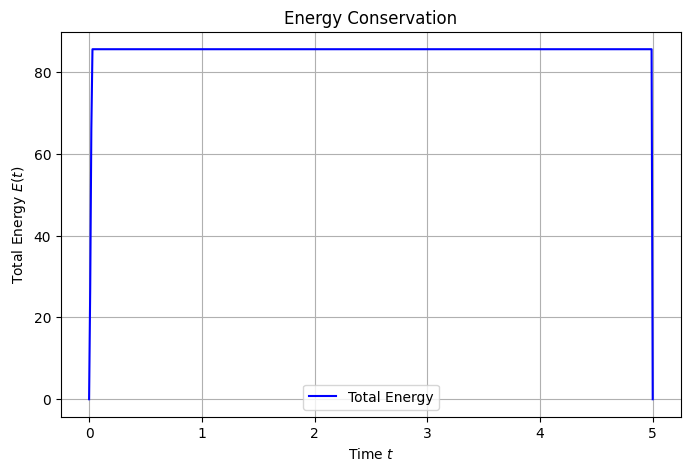

In [ ]:

# --- Simulation Parameters ---
L = 10  # Length of domain
T = 5  # Total simulation time
c = 1  # Speed of light
dx = 0.01  # Spatial resolution
dt = dx / c  # Time step size
m = 0.1  # Mass term for Klein-Gordon equation
r0 = 1000000 # Initial ripple radius

# Create simulator instance
simulator = RippleKleinGordonSimulator(L=L, T=T, c=c, dx=dx, dt=dt, m=m, r0=r0)

# Solve Klein-Gordon equation and visualize results
simulator.solve(A=1, k=2 * np.pi / 5, plot=True)

Average Wavefront Speed: -9.98e-01 m/s (Expected: 1.00e+00 m/s)


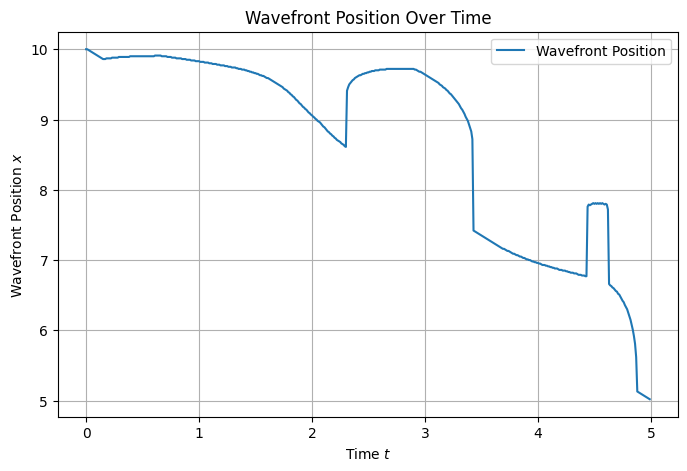

In [ ]:
def validate_wave_speed(simulator):
    """
    Validate that the wave propagates at the expected speed.
    """
    wavefront_positions = []
    for n in range(simulator.nt):
        threshold = 0.01 * np.max(np.abs(simulator.Psi[n, :]))
        wavefront = np.where(np.abs(simulator.Psi[n, :]) > threshold)[0]
        if len(wavefront) > 0:
            wavefront_positions.append(wavefront[-1] * simulator.dx)
        else:
            wavefront_positions.append(np.nan)
    
    wavefront_positions = np.array(wavefront_positions)
    valid_positions = ~np.isnan(wavefront_positions)
    valid_time = simulator.t[valid_positions]
    valid_wavefront_positions = wavefront_positions[valid_positions]

    wave_speeds = np.diff(valid_wavefront_positions) / simulator.dt
    avg_speed = np.nanmean(wave_speeds)

    print(f"Average Wavefront Speed: {avg_speed:.2e} m/s (Expected: {simulator.c:.2e} m/s)")
    
    # Plot wavefront position
    plt.figure(figsize=(8, 5))
    plt.plot(valid_time[:-1], valid_wavefront_positions[:-1], label="Wavefront Position")
    plt.xlabel("Time $t$")
    plt.ylabel("Wavefront Position $x$")
    plt.title("Wavefront Position Over Time")
    plt.grid()
    plt.legend()
    plt.show()

validate_wave_speed(simulator)

In [ ]:
def validate_numerical_stability(simulator):
    """
    Check for numerical instability by examining Psi for NaNs or infinite values.
    """
    if np.any(np.isnan(simulator.Psi)) or np.any(np.isinf(simulator.Psi)):
        print("Numerical instability detected in wavefunction!")
    else:
        print("Wavefunction is numerically stable!")

validate_numerical_stability(simulator)

Wavefunction is numerically stable!


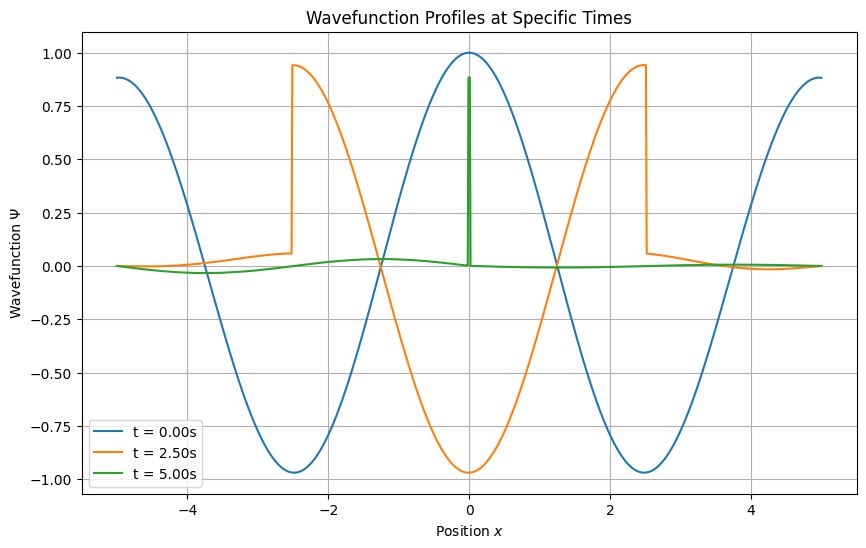

In [ ]:
def visualize_wave_profile(simulator, times):
    """
    Visualize the wavefunction at specific time steps.
    """
    plt.figure(figsize=(10, 6))
    for t in times:
        time_index = int(t / simulator.dt)
        plt.plot(simulator.x, simulator.Psi[time_index, :], label=f"t = {t:.2f}s")
    
    plt.xlabel("Position $x$")
    plt.ylabel("Wavefunction Ψ")
    plt.title("Wavefunction Profiles at Specific Times")
    plt.legend()
    plt.grid()
    plt.show()

visualize_wave_profile(simulator, times=[0, 2.5, 5])

Maximum Error Between Analytical and Numerical: 0.00e+00


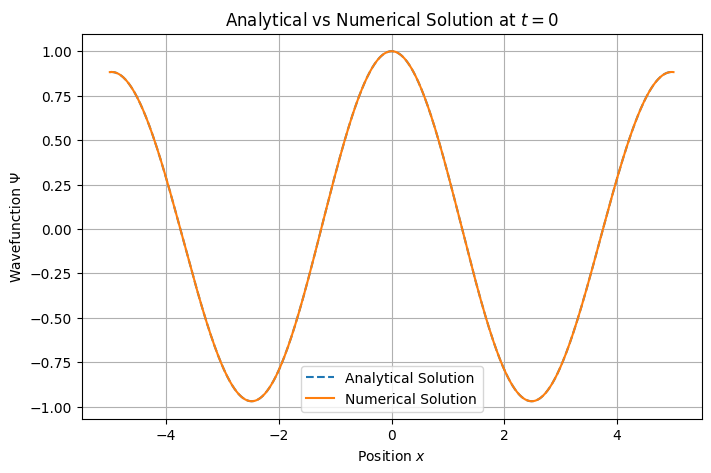

In [ ]:
def validate_against_analytical(simulator):
    """
    Compare the numerical solution to an analytical solution for simple cases.
    """
    analytical_solution = simulator.initial_wave_profile(simulator.x, A=1, k=2 * np.pi / 5, phi=0)
    numerical_solution = simulator.Psi[0, :]
    
    error = np.abs(analytical_solution - numerical_solution)
    max_error = np.max(error)
    print(f"Maximum Error Between Analytical and Numerical: {max_error:.2e}")
    
    plt.figure(figsize=(8, 5))
    plt.plot(simulator.x, analytical_solution, label="Analytical Solution", linestyle="--")
    plt.plot(simulator.x, numerical_solution, label="Numerical Solution", linestyle="-")
    plt.xlabel("Position $x$")
    plt.ylabel("Wavefunction Ψ")
    plt.title("Analytical vs Numerical Solution at $t=0$")
    plt.legend()
    plt.grid()
    plt.show()

validate_against_analytical(simulator)

Visualtion of ripple and proppably desity

In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact

def wavefunction_slideshow(simulator):
    """
    Create a slideshow-like plot to view the wavefunction Ψ(x, t) over time.
    """
    # Initialize figure
    fig, ax = plt.subplots(figsize=(10, 6))
    line, = ax.plot(simulator.x, simulator.Psi[0, :], lw=2, color='blue')
    ax.set_xlim(-simulator.L / 2, simulator.L / 2)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel("Position $x$")
    ax.set_ylabel("Wavefunction Ψ")
    ax.set_title("Wavefunction Evolution Over Time")

    # Update function for each step
    def update(frame):
        line.set_data(simulator.x, simulator.Psi[frame, :])
        ax.set_title(f"Wavefunction Evolution: Time $t={simulator.t[frame]:.2f}s$")
        fig.canvas.draw()

    # Create an interactive slider using ipywidgets
    interact(update, frame=(0, simulator.nt - 1, 1))

# Example usage
wavefunction_slideshow(simulator)

<IPython.core.display.Javascript object>

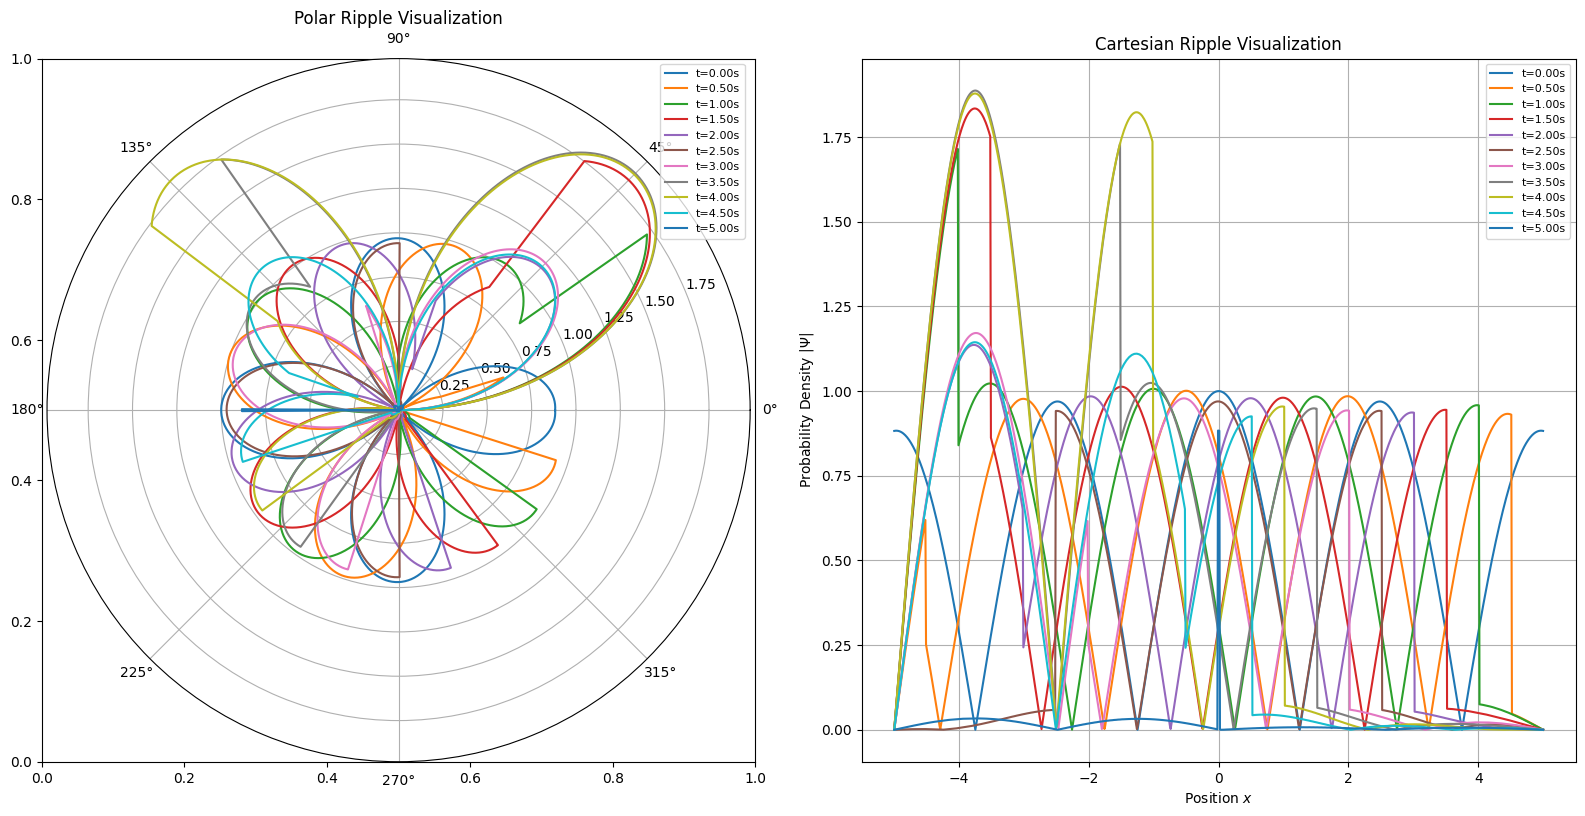

In [ ]:

%matplotlib inline
def visualize_ripple_comparison(simulator, r0):
    """
    Create both polar and Cartesian visualizations of the ripple propagation.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Polar Plot
    ax_polar = axes[0]
    ax_polar = fig.add_subplot(121, polar=True)
    theta = np.linspace(0, 2 * np.pi, simulator.nx)
    for t_idx in range(0, simulator.nt, simulator.nt // 10):
        r = np.abs(simulator.Psi[t_idx, :])  # Probability density
        ax_polar.plot(theta, r, label=f"t={simulator.t[t_idx]:.2f}s")
    ax_polar.set_title("Polar Ripple Visualization")
    ax_polar.legend(loc="upper right", fontsize=8)

    # Cartesian Plot
    ax_cartesian = axes[1]
    for t_idx in range(0, simulator.nt, simulator.nt // 10):
        x = simulator.x
        r = np.abs(simulator.Psi[t_idx, :])  # Probability density
        ax_cartesian.plot(x, r, label=f"t={simulator.t[t_idx]:.2f}s")
    ax_cartesian.set_xlabel("Position $x$")
    ax_cartesian.set_ylabel("Probability Density $|\Psi|$")
    ax_cartesian.set_title("Cartesian Ripple Visualization")
    ax_cartesian.legend(loc="upper right", fontsize=8)
    ax_cartesian.grid()

    plt.tight_layout()
    plt.show()

# Example usage
visualize_ripple_comparison(simulator, r0=1)

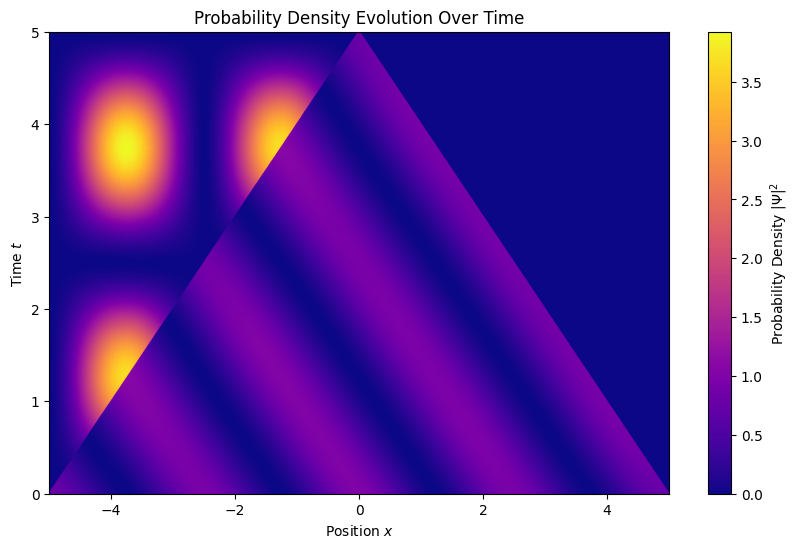

In [87]:
def visualize_probability_density(simulator):
    """
    Visualize the probability density |Ψ|^2 over time.
    """
    plt.figure(figsize=(10, 6))
    plt.imshow(
        np.abs(simulator.Psi) ** 2,
        extent=[-simulator.L / 2, simulator.L / 2, 0, simulator.T],
        origin="lower",
        aspect="auto",
        cmap="plasma",
    )
    plt.colorbar(label="Probability Density $|\Psi|^2$")
    plt.xlabel("Position $x$")
    plt.ylabel("Time $t$")
    plt.title("Probability Density Evolution Over Time")
    plt.show()

# Example usage
visualize_probability_density(simulator)